# Pre-requisites

In [1]:
!pip install datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from datasets import load_dataset #Dataset, IterableDataset
import pprint
import json
import spacy
from google.colab import drive
drive.mount('/content/drive')
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from spacy import displacy
from tqdm import tqdm
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datasets import load_dataset, load_from_disk, Dataset

Mounted at /content/drive


# Loading Test Set for Evaluation

In [3]:
path = '/content/drive/MyDrive/266 - Natural Language Processing/Final Project/'

In [4]:
# full, test dataset select data slicing of original json
# global variables
model_name = 'en_core_web_sm' # update to select the right path
task = 'mask'
size = 'mini'
split = 'test'

In [5]:
# general functions
def select_data(split, task, size):
    """
    Loads the appropriate dataset per folder structure here: https://drive.google.com/drive/folders/1C3h3rXdbr9nVAC3_G_I-72DfKNiDU_Pa
    Input:
        Split: ['train', 'val', 'test']
        Task: ['ner', 'mask', 'both']
        Size: ['testing', 'mini', 'full']
    Returns:
        Huggingface dataset
    """
    if split not in ['train', 'val', 'test']:
        raise ValueError("Split value must be in ['train', 'val', 'test']")
    if task not in ['ner', 'mask', 'both']:
        raise ValueError("Task value must be in ['ner', 'mask', 'both']")
    if size not in ['testing', 'mini', 'full']:
        raise ValueError("Size value must be in ['testing', 'mini', 'full']")

    path_label = {'both': 'longformer', 'ner': 'longformer_ner', 'mask': 'longformer_mask'}
    # path_label = {'both': 'longformer', 'ner': 'longformer_ner', 'mask': 'longformer_4096'}

    if size == 'testing':
        ds = load_from_disk(f'{path}/data/tab/{path_label[task]}/lf_{split}_testing')
    if size == 'mini':
        if split == 'train':
            ds = load_from_disk(f'{path}/data/tab/{path_label[task]}/lf_{split}_400')
        else:
            ds = load_from_disk(f'{path}/data/tab/{path_label[task]}/lf_{split}_50')
    if size == 'full':
        ds = load_from_disk(f'{path}/data/tab/{path_label[task]}/lf_{split}')

    return ds

In [6]:
ds = select_data(split, task, size)
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'ner_tags', 'mask_tags', 'text_spans', 'tokens', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 50
    })
})

In [7]:
#ds = load_dataset('json', data_files=f'{path}data/tab/echr_{split}_{size}_{task}_filtered.json')
#ds

    ner_type = ['O', 'B-PERSON', 'I-PERSON', 'B-CODE', 'I-CODE', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG',
                'B-DEM', 'I-DEM', 'B-DATETIME', 'I-DATETIME', 'B-QUANTITY', 'I-QUANTITY', 'B-MISC', 'I-MISC']
    masking_type = ['NO_MASK', 'DIRECT', 'QUASI']

In [8]:
nlp = spacy.load("en_core_web_sm")

# Functions

In [9]:
def print_entities(pipeline, text):

    # Create a document
    document = pipeline(text)

    # Entity text & label extraction
    for entity in document.ents:
        print(entity.text + '->', entity.label_)

    # Show entities in pretty manner
    #displacy.render(document, jupyter=True, style='ent')

In [10]:
def visualize_entities(model, text):

    # Create a document
    document = model(text)

    # Show entities in pretty manner
    displacy.render(document, jupyter=True, style='ent')
    #from spacy import displacy
    #displacy.render(doc, style='dep', jupyter=True, options={'distance': 130})

# Sample spaCy Output

In [11]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'ner_tags', 'mask_tags', 'text_spans', 'tokens', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 50
    })
})

In [12]:
ds['train'][0]['id']

'001-61807'

In [13]:
ds['train'][0]['text']

'PROCEDURE\n\nThe case originated in an application (no. 36110/97) against the Republic of Turkey lodged with the European Commission of Human Rights (“the Commission”) under former Article 25 of the Convention for the Protection of Human Rights and Fundamental Freedoms (“the Convention”) by four Turkish nationals, Mr Galip Yalman, Mr Bahattin Sarısoy, Mr Osman Çağlayan and Mr Yusuf Çamca (“the applicants”), on 29 November 1996.\n\nThe applicants were represented by Mr S. Esmer, a lawyer practising in Ankara. The Turkish Government (“the Government”) did not designate an Agent for the purposes of the proceedings before the Convention institutions.\n\nThe applicants alleged that their case, which commenced in 1989 and terminated in 1996, was not heard within a reasonable time as required by the Convention.\n\nThe application was transmitted to the Court on 1 November 1998, when Protocol No. 11 to the Convention came into force (Article 5 § 2 of Protocol No. 11).\n\nThe application was a

In [14]:
doc_nlp = nlp(ds['train'][0]['text'])

In [15]:
print_entities(nlp, ds['train'][0]['text'])

36110/97-> CARDINAL
the Republic of Turkey-> GPE
the European Commission of Human Rights-> ORG
Article 25 of the Convention for the Protection of Human Rights and Fundamental Freedoms-> LAW
the Convention-> WORK_OF_ART
four-> CARDINAL
Turkish-> NORP
Galip Yalman-> PERSON
Bahattin Sarısoy-> PERSON
Osman Çağlayan-> PERSON
Yusuf Çamca-> PERSON
29 November 1996-> DATE
Mr S. Esmer-> PERSON
Ankara-> GPE
The Turkish Government-> ORG
Convention-> ORG
1989-> DATE
1996-> DATE
Court-> ORG
1 November 1998-> DATE
Protocol No. 11-> PRODUCT
Article 5 § 2 of Protocol-> LAW
the Second Section of the Court-> EVENT
52-> CARDINAL
the Rules of Court-> ORG
Section-> ORG
Chamber-> ORG
Article 27 § 1-> LAW
26-> CARDINAL
1 November 2001-> DATE
Court-> ORG
25-> CARDINAL
52-> CARDINAL
15 May 2003-> DATE
Court-> ORG
59-> CARDINAL
September 1980-> DATE
The Erzincan Military Public Prosecutor-> ORG
the Erzincan Martial Law Court-> ORG
Article 146 of the Criminal Code-> LAW
between 1982 and 1984-> DATE
13 September 

In [16]:
visualize_entities(nlp, ds['train'][0]['text'])

# Evaluation

Assuming that DIRECT or QUASI mask types are both masked per the publication

In [25]:
def predict_mask_labels(dataset):
    """
    Uses spaCy's pre-trained NER to predict binary MASK labels for tokens in each text,
    calculating end positions based on token start positions.
    """
    predictions = []
    ground_truths = []

    for example in tqdm(dataset):
        text = example['text']
        mask_tags = example['mask_tags']  # Ground truth mask tags (1 or 2 for MASK, 0 for NO MASK)

        # Convert mask_tags to binary (1 for MASK, 0 for NO MASK)
        binary_ground_truths = [1 if tag in [3,4,5,6] else 0 for tag in mask_tags]

        doc = nlp(text)  # Run spaCy's NER on the text

        # Initialize all tokens as NO MASK (0), and set entities to MASK (1)
        predicted_mask_tags = [0] * len(example['tokens'])
        num_tokens = len(example['tokens'])

        for ent in doc.ents:
            # Loop through tokens and assign MASK based on entity spans
            for i, token_start in enumerate(example['text_spans']):
                # Calculate end position of the token
                if i < num_tokens - 1:
                    token_end = example['text_spans'][i + 1]
                else:
                    token_end = len(text)  # Last token to end of text

                # Check if the token is within the entity span
                if token_start >= ent.start_char and token_start < ent.end_char:
                    predicted_mask_tags[i] = 1  # Set as MASK

        predictions.extend(predicted_mask_tags)
        ground_truths.extend(binary_ground_truths)

    return predictions, ground_truths


In [26]:
# Load and preprocess dataset


# Run prediction and gather results
predictions, ground_truths = predict_mask_labels(ds['train'])

# Evaluate using classification report
print(classification_report(ground_truths, predictions, target_names=["NO MASK", "MASK"]))

100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


              precision    recall  f1-score   support

     NO MASK       0.98      0.87      0.92     56263
        MASK       0.46      0.83      0.59      7314

    accuracy                           0.87     63577
   macro avg       0.72      0.85      0.76     63577
weighted avg       0.92      0.87      0.88     63577



In [21]:
len(predictions)

63577

In [24]:
ds['train'][0]['mask_tags']

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 3,
 4,
 4,
 0,
 5,
 6,
 6,
 0,
 5,
 6,
 6,
 0,
 5,
 6,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 6,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 6,
 6,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


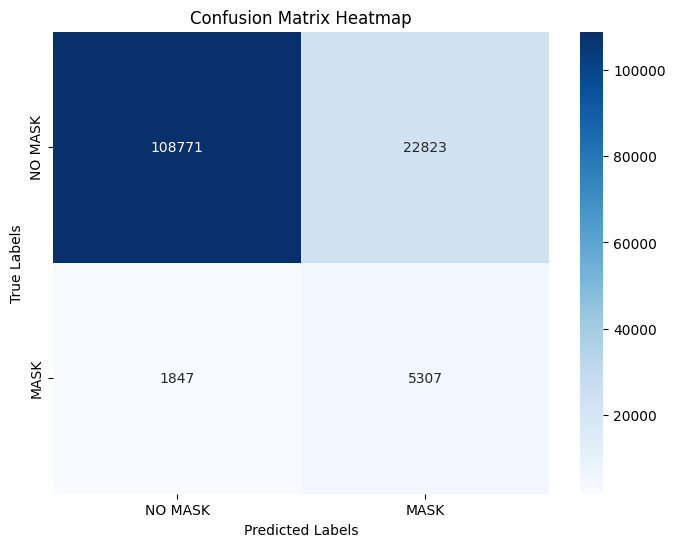

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(ground_truths, predictions)

# Plotting the heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["NO MASK", "MASK"], yticklabels=["NO MASK", "MASK"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [ ]:
len(predictions)

138748

# Anonymize

Store entity mask and binary mask outputs

In [ ]:
def anonymize_text(dataset, use_ner_tags=True):
    """
    Anonymizes each text in the dataset by replacing entities with their NER tags or
    using mask tags. If use_ner_tags=True, replaces entities with their NER tags.
    If False, replaces entities with [MASK] and non-entities with [NO MASK],
    while keeping the original token for [NO MASK].
    """
    anonymized_texts = []  # List to store anonymized texts for each example
    minimal_data = {}      # Dictionary to store minimal data with `doc_id` as keys

    for example in tqdm(dataset, desc="Anonymizing dataset"):
        text = example['text']
        doc_id = example["id"]

        # Process the text with spaCy
        doc = nlp(text)

        # Create a list to hold the anonymized tokens and masked spans for this example
        anonymized_tokens = []
        masked_spans = []

        for token in doc:
            if use_ner_tags and token.ent_type_:
                # Replace token with NER tag if it has one
                anonymized_tokens.append(f"[{token.ent_type_}]")
                masked_spans.append((token.idx, token.idx + len(token.text)))
            elif not use_ner_tags:
                # Replace entity with [MASK], keep original token for [NO MASK]
                if token.ent_type_:
                    anonymized_tokens.append("[MASK]")
                    masked_spans.append((token.idx, token.idx + len(token.text)))
                else:
                    anonymized_tokens.append(token.text)  # Keep original token for non-entities
            else:
                # Keep non-entity tokens as is if not using mask tags
                anonymized_tokens.append(token.text)

        # Join the tokens to form the anonymized text for this example
        anonymized_text = " ".join(anonymized_tokens)
        anonymized_texts.append({
            "doc_id": doc_id,
            "original_text": text,
            "anonymized_text": anonymized_text
        })

        # Store in minimal data dictionary with doc_id as key
        minimal_data[doc_id] = {
            "doc_id": doc_id,
            "masked_spans": masked_spans
        }

    return anonymized_texts, minimal_data

In [ ]:
# Anonymize all texts in the dataset using NER tags
ner_tagged_texts,ner_tagged_texts_minimal = anonymize_text(ds['train'], use_ner_tags=True)

# Anonymize all texts in the dataset using Mask tags
mask_tagged_texts,mask_tagged_texts_minimal = anonymize_text(ds['train'], use_ner_tags=False)


Anonymizing dataset: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]


In [ ]:

# Save the output to JSON files
with open(f'{path}data/tab/echr_{model_name}_{split}_{size}_{task}_ner_spans_gold.json', "w") as ner_file:
    json.dump(ner_tagged_texts, ner_file, indent=4)

with open(f'{path}data/tab/echr_{model_name}_{split}_{size}_{task}_ner_spans.json', "w") as ner_file:
    json.dump(ner_tagged_texts_minimal, ner_file, indent=4)

with open(f'{path}data/tab/echr_{model_name}_{split}_{size}_{task}_masked_spans_gold.json', "w") as mask_file:
    json.dump(mask_tagged_texts, mask_file, indent=4)

with open(f'{path}data/tab/echr_{model_name}_{split}_{size}_{task}_masked_spans.json', "w") as mask_file:
    json.dump(mask_tagged_texts_minimal, mask_file, indent=4)

print("Reconstructed texts saved as JSON files.")

Reconstructed texts saved as JSON files.
